In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from scipy.spatial import distance
import cv2
import matplotlib.patheffects as pe
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/Users/junwoopark/Downloads/python/SPT_a/andi_datasets/utils_videos.py:22: UserWarning: From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.
  warnings.warn('From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.')


In [2]:
model_num = 24

In [3]:
N = 10
T = 200
L = None

WINDOW_WIDTHS = np.arange(10, 100, 2)
SHIFT_WIDTH = 40
JUMP_D = 2

In [4]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [5]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        vals = []
        for checkpoint in range(win_widths[-1]//2, len(x_pos) - win_widths[-1]//2):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 #/ win_width
            xs2 = xs2 #/ win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 #/ win_width 
            ys2 = ys2 #/ win_width
            
            """
            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))
            """
            vals.append( abs(xs1[-1] - xs2[-1]) + abs(ys1[-1] - ys2[-1]) )
            #        * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
            #                 * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.array(vals) / 2.
        all_vals.append(vals)
    return np.array(all_vals)

In [6]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0]) / nb_activ_window
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [7]:
def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        if crop.shape[1] != shift_width:
            crop = np.hstack((crop, np.zeros((crop.shape[0], shift_width - crop.shape[1])) ))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [8]:
def merge_close_points(changepoints, signal, pred_probas, seuil=5):
    seq_sums = []
    val_orders = np.argsort(np.sum(signal[:, changepoints], axis=0))[::-1]
    #val_orders = np.argsort(pred_probas)[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [9]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)

    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    sliced_signals, slice_indice = slice_data(signal, jump_d, min(data.shape[0], ext_width), shift_width)

    return (signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
            norm_signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
           sliced_signals,
           slice_indice,
           signal)

In [10]:
def climb_mountain(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0<=x<signal.shape[0] else -1 for x in range(cp-seuil,cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp

In [11]:
def press_cp(cps, jump_d):
    filtered_cps = []
    if len(cps) == 0:
        return []
    if len(cps) == 1:
        return cps
    
    for i in range(len(cps)):
        if i == 0:
            if cps[i] + jump_d == cps[i+1]:
                filtered_cps.append(cps[i])
        elif i == len(cps) - 1:
            if cps[i] - jump_d == cps[i-1]:
                filtered_cps.append(cps[i])
        else:
            if cps[i] == cps[i-1] + jump_d or cps[i] == cps[i+1] - jump_d:
                filtered_cps.append(cps[i])
    return np.array(filtered_cps)
    

In [12]:
def slice_sum_divide(slices, jump_d, shift_width):
    slice_d = []
    for i in range(0, slices.shape[0], jump_d):
        crop = slices[i - shift_width//2: i + shift_width//2]
        if i <= shift_width//2:
            crop = np.hstack((np.zeros((shift_width - crop.shape[0])), crop))
        elif i >= slices.shape[0] - shift_width//2:
            crop = np.hstack((crop, np.zeros((shift_width - crop.shape[0]))))
        slice_d.append(crop)
    return np.array(slice_d)

In [13]:
def ana_cp_predict(model, x, y, win_widths, jump_d, check_proba=False):
    cps = []
    cps_before_reg = []
    if x.shape[0] <  win_widths[0]:
        return cps
    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1]//2,
                                                                                       jump_d,
                                                                                      SHIFT_WIDTH)
    #signal, norm_signal = make_signal(x, y, win_widths)
    #input_signals, indice = slice_data(signal, jump_d=jump_d)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    
    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        pred_org = pred.copy()
        #cps = indice[np.round(pred) >= 1]
        cps = indice[pred >= 0.5]
        cps_before_reg = cps.copy()

        if check_proba:
            for k, i in enumerate(range(0, x.shape[0], jump_d)):
                print(np.round(pred[k], 3), i, end='     ')
            print()
            

    if len(cps) == 0:
        return cps, cps_before_reg, np.round(pred_org, 3)

    reg_inputs = input_signals[cps//jump_d,:,:,:]
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()

    if check_proba:
        print(np.hstack((cps, reg_outputs)).reshape(-1, 2))
    
    app_indice = np.argwhere(abs(reg_outputs) < jump_d*2).flatten()
    cps = cps[app_indice]
    reg_outputs = reg_outputs[app_indice]
    cps = np.round(cps + reg_outputs).astype(int)

    input_signals = []
    indices = []
    cps_doublecheck = []

    for cp_check in cps:
        if cp_check <= 0 or cp_check >= x.shape[0]:
            continue
        indices.append(cp_check)
        input_signals.append(ext_signal[:, min(x.shape[0], win_widths[-1]//2) + cp_check - SHIFT_WIDTH//2:
                              min(x.shape[0], win_widths[-1]//2) + cp_check + SHIFT_WIDTH//2])

    if len(indices) == 0:
        return [], np.sort(cps_before_reg), np.round(pred_org, 3)
        
    input_signals = np.array(input_signals)
    input_signals = input_signals.reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)

    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        cps_doublecheck = np.array(indices)[np.argwhere(pred >= 0.5).flatten()]
        pred_probas = pred[np.argwhere(pred >= 0.5).flatten()]
        
    if len(cps_doublecheck) > 0:
        cps_doublecheck = merge_close_points(np.array(cps_doublecheck), signal, pred_probas, seuil=3)
    return np.sort(cps_doublecheck), np.sort(cps_before_reg), np.round(pred_org, 3)

In [17]:
classification_model = tf.keras.models.load_model(f'./models/{model_num}/cls_model_{SHIFT_WIDTH}_2.keras')
regression_model = tf.keras.models.load_model(f'./models/{model_num}/reg_model_{SHIFT_WIDTH}_2.keras')

In [15]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

track = 2
exp = 5
fovs = [0]
traj_idx = [0] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check,, exp10,fov0,idx7 check
checkpoints = [0]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        print('Trajectory legnth: ', x.shape)
        # Assign one changepoints for each traj at 0.25 of its length

        cps,pred_p = ana_cp_predict2(classification_model,
                                      x,
                                      y,
                                      WINDOW_WIDTHS,
                                      JUMP_D,
                                      SHIFT_WIDTH,
                                      True)
        #cps_before_reg = np.setdiff1d(cps_before_reg, [x for x in np.concatenate((np.arange(3), np.arange(length_traj-3, length_traj)))])
        #print(cps_before_reg)
        
        print(f'CPS: {cps}')
        
        signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y, 
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  JUMP_D,
                                                                                  SHIFT_WIDTH)
        
        plt.figure(figsize=(8, 8))
        plt.plot(x, y, linewidth=0.8)
        plt.xlim([np.min(x) - 25,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 25])
        plt.ylim([np.min(y) - 25,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 25])
        for checkpoint in checkpoints:
            plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
        plt.scatter(x[0], y[0], marker='>', c='red')
        plt.scatter(x[-1], y[-1], marker='<', c='blue')
        
        for cp in cps:
            plt.scatter(x[cp], y[cp], c='red')
        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
        for cp in cps:
            ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], c='red', alpha=0.6)

        ax.set_xlim([np.min(x) - 10,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 10])
        ax.set_ylim([np.min(y) - 10,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 10])
        ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
        ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
        for checkpoint in checkpoints:
            ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

        plt.figure()
        for i in range(signals.shape[0]):
            plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.2,
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])
        plt.scatter(cps, np.array([np.max(signals) + 1] * len(cps)), c='green')
        #plt.scatter(cps_before_reg, np.array([np.max(signals)] * len(cps_before_reg)), c='red')
        plt.ylim([0, max(10, np.max(signals)) + 2])
        
        plt.figure()
        for i in range(norm_signals.shape[0]):
            plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.2, 
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])
        comp_signal = compress_signals(norm_signals)
        #plt.plot(np.arange(signals.shape[1]), comp_signal / SNR / np.max(comp_signal / SNR), c='red')
        #plt.plot(np.arange(signals.shape[1]), comp_signal, c='black')
        plt.scatter(cps, np.array([np.max(comp_signal) + 0.2] * len(cps)), c='green')
        #plt.scatter(cps_before_reg, np.array([np.max(comp_signal) + 0.1] * len(cps_before_reg)), c='red')
        plt.plot(np.arange(0, signals.shape[1], JUMP_D), pred_p, c='black')
        
        
        
        
 
        signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  10)
        cps = press_cp(cps, JUMP_D)
        slice_sum = np.sum(sliced_signals, axis=(1, 2))

        slice_sum /= np.max(slice_sum)
        plt.plot(np.arange(slice_sum.shape[0]), slice_sum, c='brown')
        print(f'slice_mean: {np.mean(slice_sum)}, slice_std: {np.std(slice_sum)}')
        print(f'slice_sum_SNR: {np.mean(slice_sum)**2 / np.std(slice_sum)**2}')
        merged_cps = list(map(climb_mountain,
                              [slice_sum] * len(cps),
                              cps,
                             [5 * JUMP_D ] * len(cps)))
        merged_cps = np.sort(np.unique(merged_cps))
        if -1 in merged_cps:
            merged_cps = np.delete(merged_cps, 0)
        plt.scatter(merged_cps, np.array([np.max(slice_sum) + 0.2] * len(merged_cps)), c='black')
        for idx, mer_cp in enumerate(merged_cps):
            merged_cps[idx] = cps[np.argmin(abs(cp - float(mer_cp)))]

        
        reg_inputs = []
        for merged_cp in merged_cps:
            xx = signals[:, max(0, -SHIFT_WIDTH//2 + merged_cp) : min(signals.shape[1], SHIFT_WIDTH//2 + merged_cp)]
            if merged_cp < SHIFT_WIDTH//2:
                xx = np.hstack((np.zeros((xx.shape[0], SHIFT_WIDTH - xx.shape[1])), xx))
            elif merged_cp > signals.shape[1] - SHIFT_WIDTH//2:
                xx = np.hstack((xx, np.zeros((xx.shape[0], SHIFT_WIDTH - xx.shape[1]))))             
            reg_inputs.append(xx)
        reg_inputs = np.array(reg_inputs).reshape(-1, signals.shape[0], SHIFT_WIDTH, 1)
        if reg_inputs.shape[0] != 0:
            reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
            final_cps = np.round(merged_cps + reg_outputs).astype(int)
            final_cps = merge_close_points(final_cps, signals, None, seuil=3)
            plt.scatter(final_cps, np.array([np.max(slice_sum) + 0.25] * len(final_cps)), c='orange')
            for aa in final_cps:
                ax.scatter3D(x[aa], y[aa], np.arange(signals.shape[1])[aa], marker='+', c='blue', alpha=0.7)

        

    

Trajectory legnth:  (32,)


NameError: name 'ana_cp_predict2' is not defined

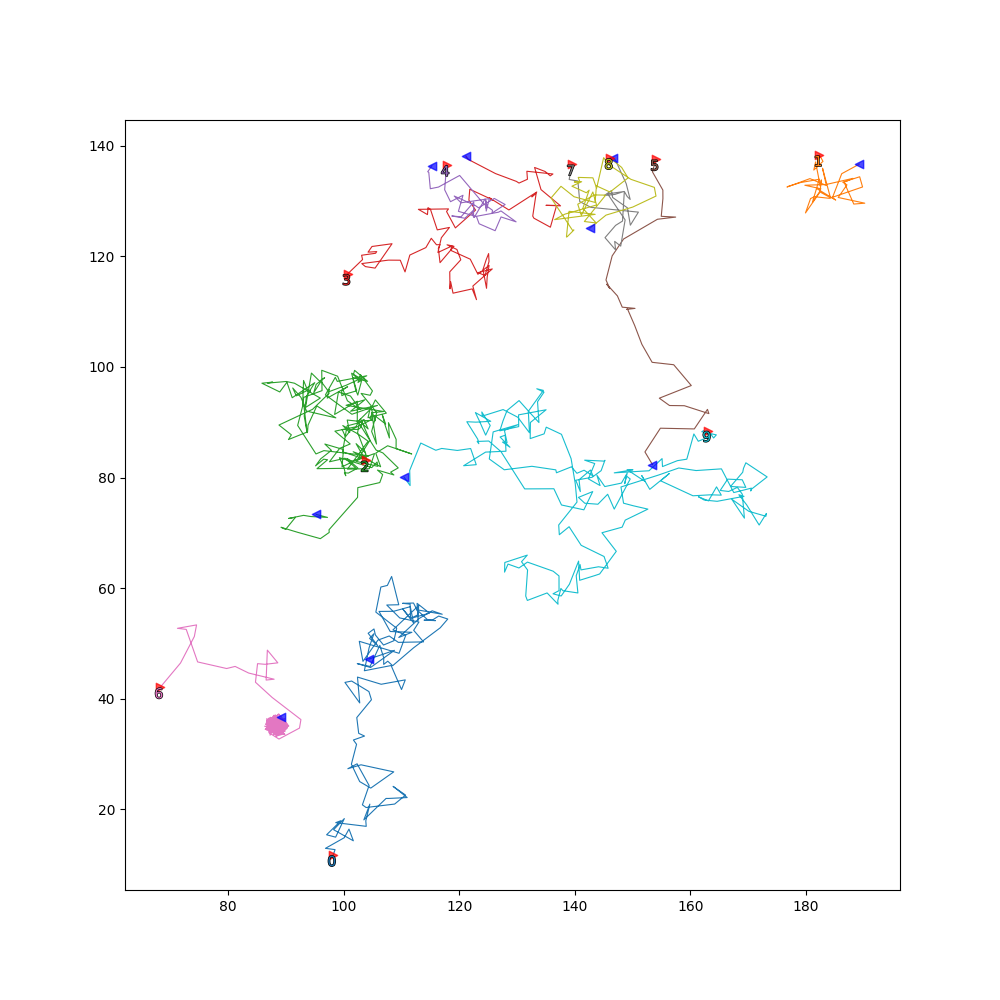

In [31]:
track = 2
exp = 0
fovs = [3]
check_indice = [0, 10]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
    plt.figure(figsize=(10, 10))
    for idx in np.unique(df.traj_idx).astype(int)[check_indice[0]: check_indice[1]]:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        #cps, _ = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)

        trajectory = plt.plot(x, y, linewidth=0.8, zorder=0)
        plt.scatter(x[0], y[0], marker='>', c='red', zorder=1, alpha=0.7)
        plt.annotate(str(idx), xy=(x[0]-1,y[0]-2), color=trajectory[0].get_color(), path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        plt.scatter(x[-1], y[-1], marker='<', c='blue', zorder=1, alpha=0.7)
        #for cp in cps:
        #    plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2) 


# Produce a trajectory and check signals

In [264]:
def ana_cp_predict2(model, x, y, win_widths, jump_d, shift_width, check_proba=False):
    cps = []
    if x.shape[0] < win_widths[0]:
        return cps

    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1] // 2,
                                                                                       jump_d,
                                                                                       shift_width)

    _, _, sliced_signals, _, _ = signal_from_extended_data(x, y,
                                                           win_widths,
                                                           win_widths[-1] // 2,
                                                           1,
                                                           10)

    slice_sum = np.sum(sliced_signals, axis=(1, 2))
    slice_sum /= np.max(slice_sum)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1) ** 2 / np.std(signal, axis=1) ** 2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    input_slice_sum = slice_sum_divide(slice_sum, jump_d, shift_width).reshape(-1, 1, SHIFT_WIDTH, 1)
    input_slice_snr = np.array([np.mean(slice_sum)**2 / np.std(slice_sum)**2] * input_slice_sum.shape[0])


    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1, input_slice_sum, input_slice_snr], verbose=0).flatten()
        cps = indice[pred >= 0.5]

    cps = press_cp(cps, jump_d)
    if len(cps) == 0:
        return cps, pred



    merged_cps = list(map(climb_mountain,
                          [slice_sum] * len(cps),
                          cps,
                          [5 * jump_d] * len(cps)))
    merged_cps = np.sort(np.unique(merged_cps))
    if -1 in merged_cps:
        merged_cps = np.delete(merged_cps, 0)
    for idx, mer_cp in enumerate(merged_cps):
        merged_cps[idx] = cps[np.argmin(abs(cps - float(mer_cp)))]

    reg_inputs = []
    for merged_cp in merged_cps:
        xx = signal[:, max(0, -shift_width//2 + merged_cp) : min(signal.shape[1], shift_width//2 + merged_cp)]
        if merged_cp < shift_width//2:
            xx = np.hstack((np.zeros((xx.shape[0], shift_width - xx.shape[1])), xx))
        elif merged_cp > signal.shape[1] - shift_width//2:
            xx = np.hstack((xx, np.zeros((xx.shape[0], shift_width - xx.shape[1]))))
        reg_inputs.append(xx)
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], shift_width, 1)

    if len(merged_cps) != 0:
        reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
        final_cps = np.round(merged_cps + reg_outputs).astype(int)
        final_cps = merge_close_points(final_cps, signal, None, seuil=3)
        return np.sort(final_cps), pred
    else:
        return [], pred

In [292]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=200,
                                                        alphas=[1.5, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[1.0, 0.0], [0.0, 1.0]]
                                                       )

GT: [75 79 93 97]
Pred: [74 98]
slice_mean: 0.16282983320791622, slice_std: 0.2572738825393502
slice_sum_SNR: 0.40056827938735856
slice_sum_SNR: 569.8238765161785


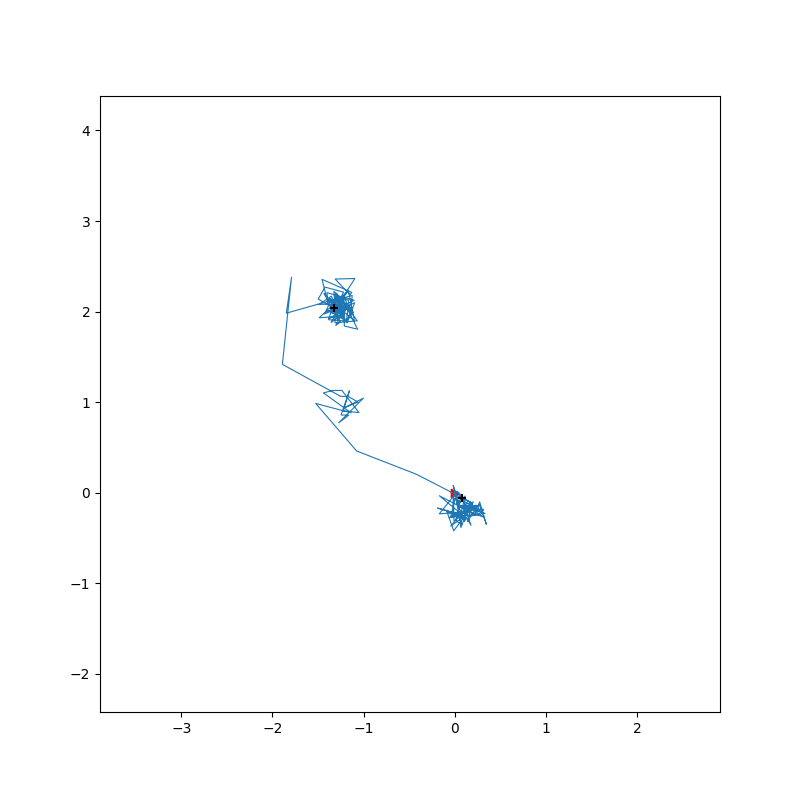

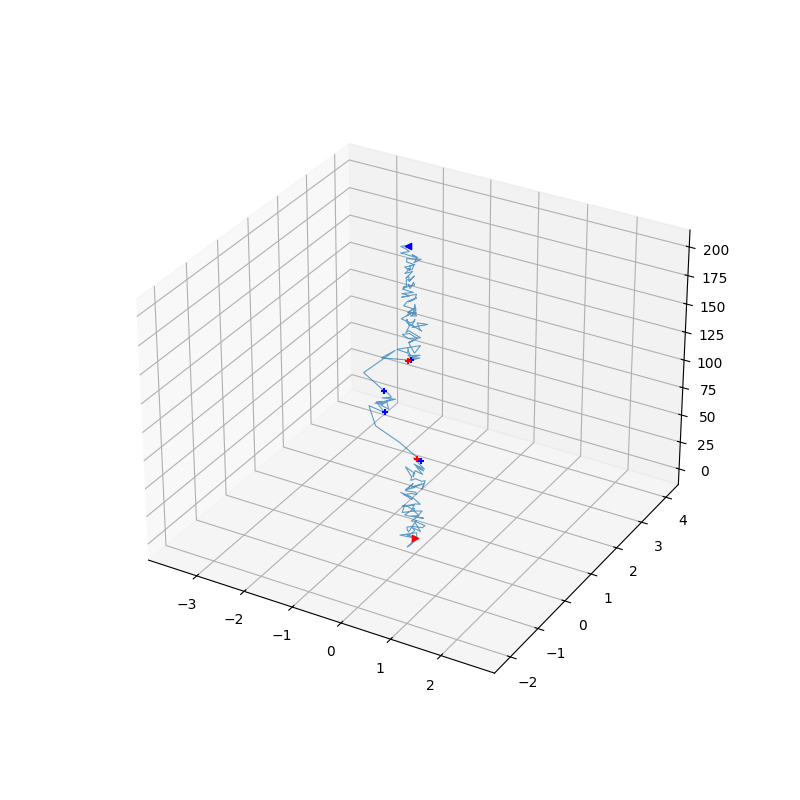

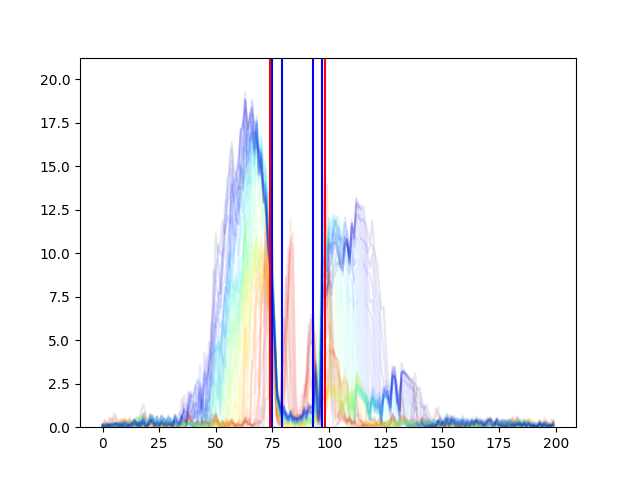

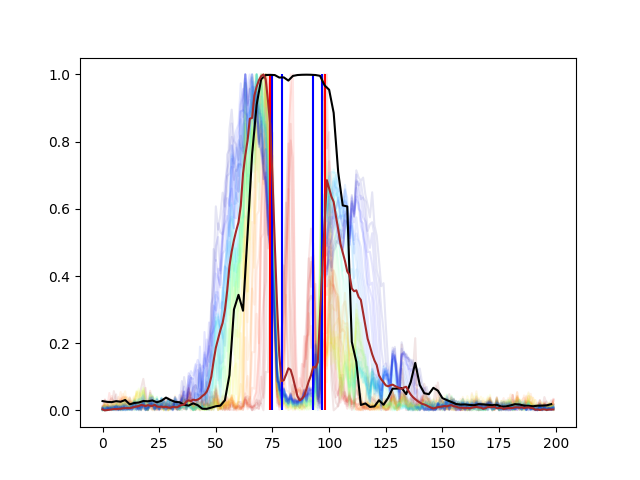

In [284]:
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
cps,pred_p = ana_cp_predict2(classification_model,
                              trajs_model[:, 0, 0],
                              trajs_model[:, 0, 1],
                              WINDOW_WIDTHS,
                              JUMP_D,
                              SHIFT_WIDTH,
                              True)

changepoints = changepoints[:-1]
print(f'GT: {changepoints}')
print(f'Pred: {cps}')

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]
        
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]

signals, norm_signals, _ , _ , _ = signal_from_extended_data(x, y,
                                                             WINDOW_WIDTHS,
                                                             WINDOW_WIDTHS[-1]//2,
                                                             JUMP_D,
                                                             SHIFT_WIDTH)
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in cps:
    plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in cps:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='red', zorder=2)
for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)

plt.figure()
plt.ylim([0, max(10, np.max(signals)) + 2])
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, max(10, np.max(signals)) + 2, color='blue')

for cp in cps:
    plt.vlines(cp, 0, max(10, np.max(signals)) + 2, color='red')

        
plt.figure()
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

for cp in cps:
    plt.vlines(cp, 0, 1, color='red')

plt.plot(np.arange(0, signals.shape[1], JUMP_D), pred_p, c='black')


signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  5)

slice_sum = np.sum(sliced_signals, axis=(1, 2))
slice_sum -= np.min(slice_sum)
slice_sum /= np.max(slice_sum)

plt.plot(np.arange(slice_sum.shape[0]), slice_sum, c='brown')
print(f'slice_mean: {np.mean(slice_sum)}, slice_std: {np.std(slice_sum)}')
print(f'slice_sum_SNR: {np.mean(slice_sum)**2 / np.std(slice_sum)**2}')
print(f'slice_sum_SNR: {1 / (np.mean(slice_sum)**2 * np.std(slice_sum)**2)}')

In [28]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=200,
                                                        alphas=[0.5, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )

In [29]:
def signal_from_extended_data2(x, y, win_widths, ext_width, jump_d, shift_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)

    signal = make_signal(datas[0], datas[1], win_widths)
    sliced_signals, slice_indice = slice_data(signal, jump_d, min(data.shape[0], ext_width), shift_width)

    return (signal,
            #norm_signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
           sliced_signals,
           slice_indice,
           signal)

GT: [174]


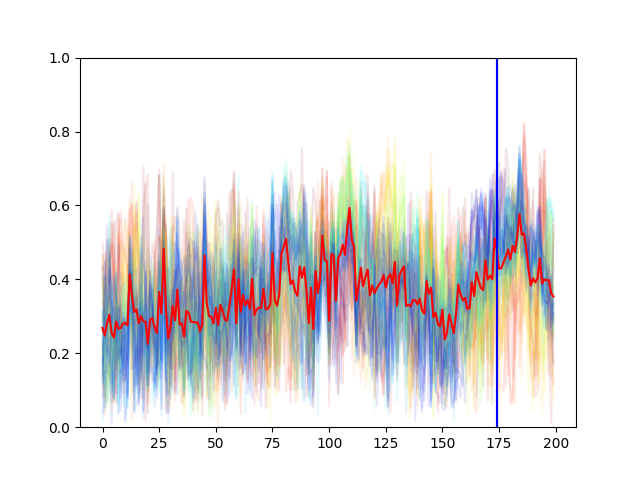

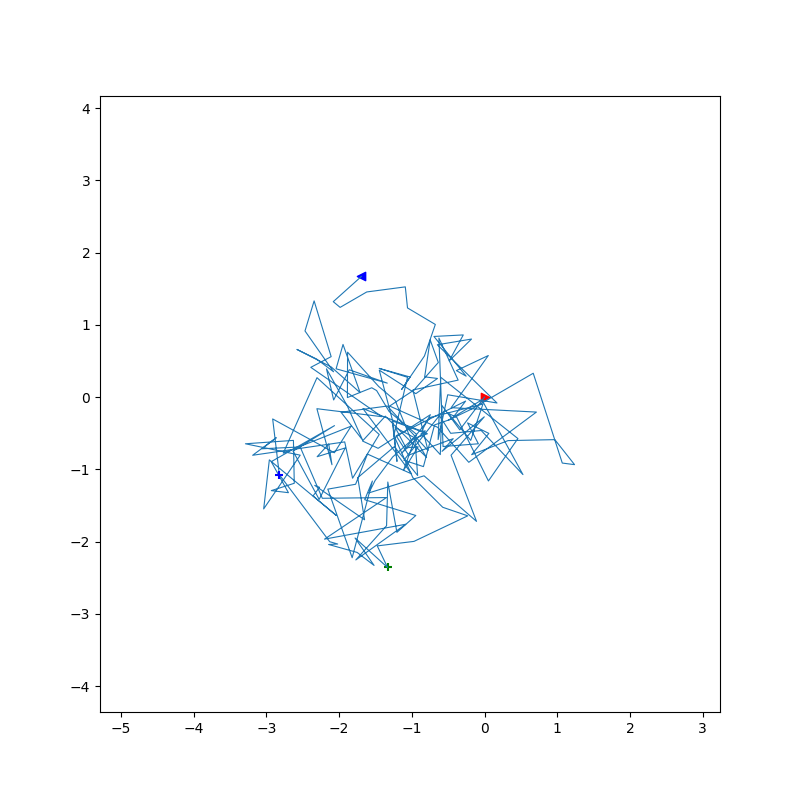

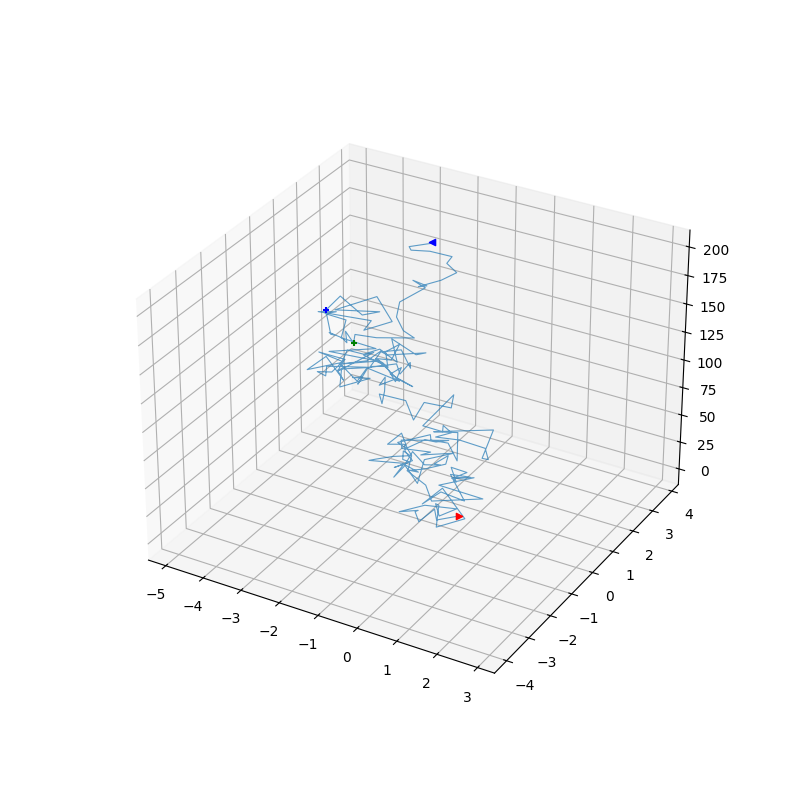

In [30]:
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])

changepoints = changepoints[:-1]
print(f'GT: {changepoints}')

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]
checkpoints = [181]
        
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]

signals, norm_signals, slice_sig , _   = signal_from_extended_data2(x, y,
                                                             WINDOW_WIDTHS,
                                                             WINDOW_WIDTHS[-1]//2,
                                                             1,
                                                            10)

plt.figure()
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.1,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])


for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')

"""
plt.plot(np.arange(0, signals.shape[1]), np.sum(slice_sig, axis=(1,2)) / np.sum(norm_signals) , c='black')
plt.figure()
for i in range(len(WINDOW_WIDTHS)):
    plt.plot(np.arange(0, signals.shape[1]), (np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1))[i],
             c=color_seq[int(i * 255 / norm_signals.shape[0])], alpha=0.3)


signals, norm_signals, sliced_signals , _ , _ = signal_from_extended_data(x, y,
                                                                                  WINDOW_WIDTHS,
                                                                                  WINDOW_WIDTHS[-1]//2,
                                                                                  1,
                                                                                  10)
"""

#val1 = np.mean(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0)
#val1 = val1 / np.max(val1)
#val2 = np.log(np.prod(np.sum(slice_sig, axis=(2)).T / np.sum(norm_signals, axis=1).reshape(-1, 1), axis=0))
#val2 = val2 - np.min(val2)
#val2 = val2 / np.max(val2)
#plt.plot(np.arange(norm_signals.shape[1]), signals, c='brown')
plt.plot(np.arange(signals.shape[1]), np.mean(signals, axis=0), c='red')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.ylim([0, 1])


plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for checkpoint in checkpoints:
    plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for checkpoint in checkpoints:
    ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')
